In [1]:
import torch
import clip
from PIL import Image
import numpy as np

In [ ]:
#!pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 12.8/12.8 MB 100.4 MB/s eta 0:00:00


In [2]:

def extract_image_regions(image_path):
    """将抠图图像分割为透明区域对象，返回每个对象的嵌入向量"""
    img = Image.open(image_path).convert("RGBA")
    
    # 提取Alpha通道并二值化
    alpha = np.array(img.getchannel('A'))
    alpha[alpha > 0] = 1  # 二值化透明通道
    
    # 查找连通区域
    from skimage.measure import label, regionprops
    label_img = label(alpha, connectivity=2)
    
    # 提取每个抠图对象的嵌入向量
    model, preprocess = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")
    region_embeddings = []
    
    props = regionprops(label_img)
    for prop in props:
        # 裁剪区域
        minr, minc, maxr, maxc = prop.bbox
        region = img.crop((minc, minr, maxc, maxr))
        
        # 转为RGB并预处理
        region_rgb = Image.new("RGBA", region.size, "WHITE")
        region_rgb.paste(region, mask=region)
        region_input = preprocess(region_rgb.convert("RGB")).unsqueeze(0)
        
        # 提取嵌入向量
        with torch.no_grad():
            region_embedding = model.encode_image(region_input.to(model.visual.conv1.weight.device))
            region_embeddings.append(region_embedding.cpu())
    
    return torch.cat(region_embeddings), len(props)

def compute_word_scores(image_path, words):
    """计算每个词语的视觉和语义匹配分数"""
    # 1. 准备CLIP模型
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    # 2. 提取图像区域特征
    region_embeddings, num_regions = extract_image_regions(image_path)
    region_embeddings = region_embeddings.to(device)
    
    # 3. 文本预处理
    tokenized_text = clip.tokenize([f"a photo that contains {word}" for word in words]).to(device)
    
    # 4. 计算文本嵌入向量
    with torch.no_grad():
        word_embeddings = model.encode_text(tokenized_text)
        word_embeddings /= word_embeddings.norm(dim=-1, keepdim=True)
    
    # 5. 计算匹配分数矩阵
    similarity_matrix = region_embeddings @ word_embeddings.T  # [regions, words]
    similarity_matrix = similarity_matrix.cpu().numpy()
    
    # 6. 为每个词语计算分数
    results = {}
    for i, word in enumerate(words):
        # 区域最大相似度（视觉匹配分数）
        visual_score = float(similarity_matrix[:, i].max())
        
        # 语义一致性得分（与全局图像相似度）
        img = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(img)
            text_features = model.encode_text(tokenized_text[i:i+1])
        
        text_features /= text_features.norm(dim=-1, keepdim=True)
        semantic_score = float((image_features @ text_features.T).squeeze().item())
        
        results[word] = {
            "visual_match": round(visual_score, 4),
            "semantic_match": round(semantic_score, 4)
        }
    
    return results

# 示例使用
if __name__ == "__main__":
    # 输入参数
    image_path = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\remaining_foregrounds\image_ (13).jpg"  # 抠图处理后的PNG图片
    word_list = ["face", "amaze", "ears", "deliciousus", "cake", "words", "sponge", "loaf", "dog"]  # 待分析词语
    
    # 处理并输出结果
    scores = compute_word_scores(image_path, word_list)
    
    print("词语匹配分数报告:")
    for word, scores in scores.items():
        print(f"- {word}:")
        print(f"  视觉匹配度: {scores['visual_match']:.4f} (最高区域匹配分数)")
        print(f"  语义匹配度: {scores['semantic_match']:.4f} (全局图像相关性)")

词语匹配分数报告:
- face:
  视觉匹配度: 2.0957 (最高区域匹配分数)
  语义匹配度: 2.0957 (全局图像相关性)
- amaze:
  视觉匹配度: 2.4531 (最高区域匹配分数)
  语义匹配度: 2.4531 (全局图像相关性)
- ears:
  视觉匹配度: 1.9590 (最高区域匹配分数)
  语义匹配度: 1.9600 (全局图像相关性)
- deliciousus:
  视觉匹配度: 2.5254 (最高区域匹配分数)
  语义匹配度: 2.5234 (全局图像相关性)
- cake:
  视觉匹配度: 2.6934 (最高区域匹配分数)
  语义匹配度: 2.6934 (全局图像相关性)
- words:
  视觉匹配度: 2.3594 (最高区域匹配分数)
  语义匹配度: 2.3613 (全局图像相关性)
- sponge:
  视觉匹配度: 2.6445 (最高区域匹配分数)
  语义匹配度: 2.6445 (全局图像相关性)
- loaf:
  视觉匹配度: 2.4629 (最高区域匹配分数)
  语义匹配度: 2.4648 (全局图像相关性)
- dog:
  视觉匹配度: 2.2812 (最高区域匹配分数)
  语义匹配度: 2.2812 (全局图像相关性)


In [3]:
import pandas as pd

csv_path = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Multimodality_understanding_text\image_keywords.csv"  # Replace with your actual CSV file path
df_csv = pd.read_csv(csv_path)
df_csv.head()

,image_file,keywords
0,image_ (0).jpg,"caption, image, eyes, LIT, seal, tears"
1,image_ (1).jpg,"image, cat, I, circle, you, cushion, font, tex..."
2,image_ (10).jpg,"candle, hat, cat, container, couch, food, part..."
3,image_ (100).jpg,"hoax, book, love, Canada, hand, person, text, ..."
4,image_ (1000).jpg,"image, monitor, expression, side, desk, shirt,..."


In [4]:
import os
import logging

# 设置日志
logging.basicConfig(filename='batch_process_log.txt', level=logging.INFO, 
                    format='%(asctime)s %(levelname)s:%(message)s')

def batch_compute_word_scores(image_dir, df_csv):
    results = []
    skipped = 0

    for idx, row in df_csv.iterrows():
        image_file = row['image_file']
        keywords = row['keywords']
        image_path = os.path.join(image_dir, image_file)
        
        # 检查图片文件是否存在
        if not os.path.isfile(image_path):
            logging.warning(f"Image not found: {image_path}")
            skipped += 1
            continue
        
        # 检查关键词有效性
        if not isinstance(keywords, str) or not keywords.strip():
            logging.warning(f"No keywords for image: {image_file}")
            skipped += 1
            continue
        
        word_list = [w.strip() for w in keywords.split(',') if w.strip()]
        if not word_list:
            logging.warning(f"Empty word list after split for image: {image_file}")
            skipped += 1
            continue
        
        try:
            score_dict = compute_word_scores(image_path, word_list)
            for word in word_list:
                if word in score_dict:
                    results.append({
                        'image_file': image_file,
                        'word': word,
                        'visual_match': score_dict[word]['visual_match'],
                        'semantic_match': score_dict[word]['semantic_match']
                    })
        except Exception as e:
            logging.error(f"Error processing {image_file}: {e}")
            skipped += 1
            continue

    df_results = pd.DataFrame(results)
    print(f"批量处理完成，跳过 {skipped} 条记录。")
    return df_results



In [ ]:
# 用法示例
image_dir = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\test"
df_results = batch_compute_word_scores(image_dir, df_csv)
df_results.head()

In [8]:
df_results.head(20)

,image_file,word,visual_match,semantic_match
0,image_ (113).jpg,him,2.5059,2.5059
1,image_ (113).jpg,street,2.4863,2.4863
2,image_ (113).jpg,image,2.7461,2.7441
3,image_ (113).jpg,woman,2.7090,2.7090
4,image_ (113).jpg,scene,2.5996,2.6016
5,image_ (113).jpg,shirt,2.8438,2.8438
6,image_ (113).jpg,plaid,2.6953,2.6973
7,image_ (113).jpg,man,2.7539,2.7539
8,image_ (113).jpg,background,2.6074,2.6074
9,image_ (113).jpg,dress,2.7422,2.7422


In [9]:
image_dir_1 = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\remaining_foregrounds"
df_main = batch_compute_word_scores(image_dir_1, df_csv)

批量处理完成，跳过 1305 条记录。


In [10]:
df_main.head()

,image_file,word,visual_match,semantic_match
0,image_ (0).jpg,caption,3.0215,3.0195
1,image_ (0).jpg,image,3.0684,3.0684
2,image_ (0).jpg,eyes,2.9219,2.9199
3,image_ (0).jpg,LIT,2.8691,2.8691
4,image_ (0).jpg,seal,3.2969,3.2988


In [12]:
# 导出 df_main 到用户自定义路径的 CSV 文件
export_path = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\df_main.csv"  # 修改为你想要保存的文件路径
df_main.to_csv(export_path, index=False)
print(f"df_main 已成功导出到: {export_path}")

df_main 已成功导出到: F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\df_main.csv


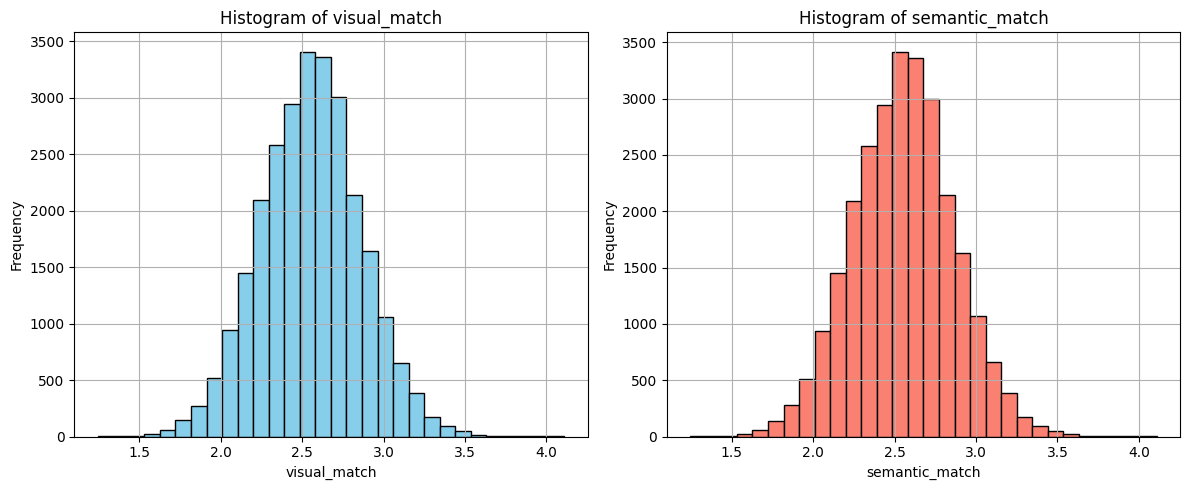

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_main['visual_match'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of visual_match')
plt.xlabel('visual_match')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df_main['semantic_match'].hist(bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of semantic_match')
plt.xlabel('semantic_match')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
# 统计分析 visual_match 和 semantic_match
print("visual_match 统计描述：")
print(df_main['visual_match'].describe())
print("\nsemantic_match 统计描述：")
print(df_main['semantic_match'].describe())

# 相关性分析
corr = df_main[['visual_match', 'semantic_match']].corr()
print("\nvisual_match 与 semantic_match 的相关系数：")
print(corr)

visual_match 统计描述：
count    27048.000000
mean         2.553633
std          0.309358
min          1.245100
25%          2.345700
50%          2.554700
75%          2.753900
max          4.109400
Name: visual_match, dtype: float64

semantic_match 统计描述：
count    27048.000000
mean         2.553772
std          0.309315
min          1.245100
25%          2.345700
50%          2.554700
75%          2.753900
max          4.109400
Name: semantic_match, dtype: float64

visual_match 与 semantic_match 的相关系数：
                visual_match  semantic_match
visual_match        1.000000        0.999993
semantic_match      0.999993        1.000000


In [5]:
image_dir = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\Matte_Filtered"
df_results = batch_compute_word_scores(image_dir, df_csv)
df_results.head()

c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


批量处理完成，跳过 1305 条记录。


,image_file,word,visual_match,semantic_match
0,image_ (0).jpg,caption,2.2344,2.2344
1,image_ (0).jpg,image,2.1680,2.1680
2,image_ (0).jpg,eyes,2.0586,2.0586
3,image_ (0).jpg,LIT,2.1133,2.1133
4,image_ (0).jpg,seal,2.8359,2.8379


In [6]:
df_results.head(10)

,image_file,word,visual_match,semantic_match
0,image_ (0).jpg,caption,2.2344,2.2344
1,image_ (0).jpg,image,2.1680,2.1680
2,image_ (0).jpg,eyes,2.0586,2.0586
3,image_ (0).jpg,LIT,2.1133,2.1133
4,image_ (0).jpg,seal,2.8359,2.8379
5,image_ (0).jpg,tears,2.0859,2.0859
6,image_ (10).jpg,candle,3.1895,3.1895
7,image_ (10).jpg,hat,3.1152,3.1172
8,image_ (10).jpg,cat,2.8887,2.8887
9,image_ (10).jpg,container,2.5000,2.5020


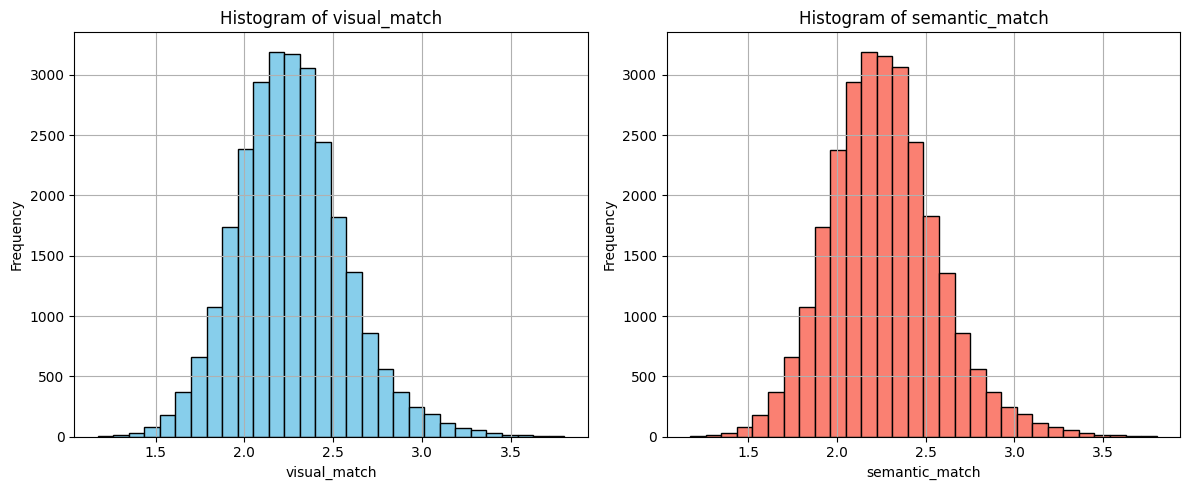

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_results['visual_match'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of visual_match')
plt.xlabel('visual_match')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df_results['semantic_match'].hist(bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of semantic_match')
plt.xlabel('semantic_match')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# 统计分析 visual_match 和 semantic_match
print("visual_match 统计描述：")
print(df_results['visual_match'].describe())
print("\nsemantic_match 统计描述：")
print(df_results['semantic_match'].describe())

# 相关性分析
corr = df_results[['visual_match', 'semantic_match']].corr()
print("\nvisual_match 与 semantic_match 的相关系数：")
print(corr)

visual_match 统计描述：
count    27048.000000
mean         2.263181
std          0.308538
min          1.173800
25%          2.056600
50%          2.246100
75%          2.447300
max          3.800800
Name: visual_match, dtype: float64

semantic_match 统计描述：
count    27048.000000
mean         2.263387
std          0.308503
min          1.173800
25%          2.056600
50%          2.248000
75%          2.447300
max          3.800800
Name: semantic_match, dtype: float64

visual_match 与 semantic_match 的相关系数：
                visual_match  semantic_match
visual_match        1.000000        0.999992
semantic_match      0.999992        1.000000


In [11]:
# 导出 df_results 到用户自定义路径的 CSV 文件
export_path = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\df_results.csv"  # 修改为你想要保存的文件路径
df_results.to_csv(export_path, index=False)
print(f"df_main 已成功导出到: {export_path}")

df_main 已成功导出到: F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\df_results.csv


In [12]:
# 导入CSV文件并命名为df_main
csv_file_path = r"F:\Github\MemePic\MemePic\Met MEME\Dataset\Raw\Direct_Added_Experience\df_main.csv"  # 修改为你的实际路径
df_main = pd.read_csv(csv_file_path)
df_main.head()

,image_file,word,visual_match,semantic_match
0,image_ (0).jpg,caption,3.0215,3.0195
1,image_ (0).jpg,image,3.0684,3.0684
2,image_ (0).jpg,eyes,2.9219,2.9199
3,image_ (0).jpg,LIT,2.8691,2.8691
4,image_ (0).jpg,seal,3.2969,3.2988


In [13]:
df_results.head()

,image_file,word,visual_match,semantic_match
0,image_ (0).jpg,caption,2.2344,2.2344
1,image_ (0).jpg,image,2.1680,2.1680
2,image_ (0).jpg,eyes,2.0586,2.0586
3,image_ (0).jpg,LIT,2.1133,2.1133
4,image_ (0).jpg,seal,2.8359,2.8379


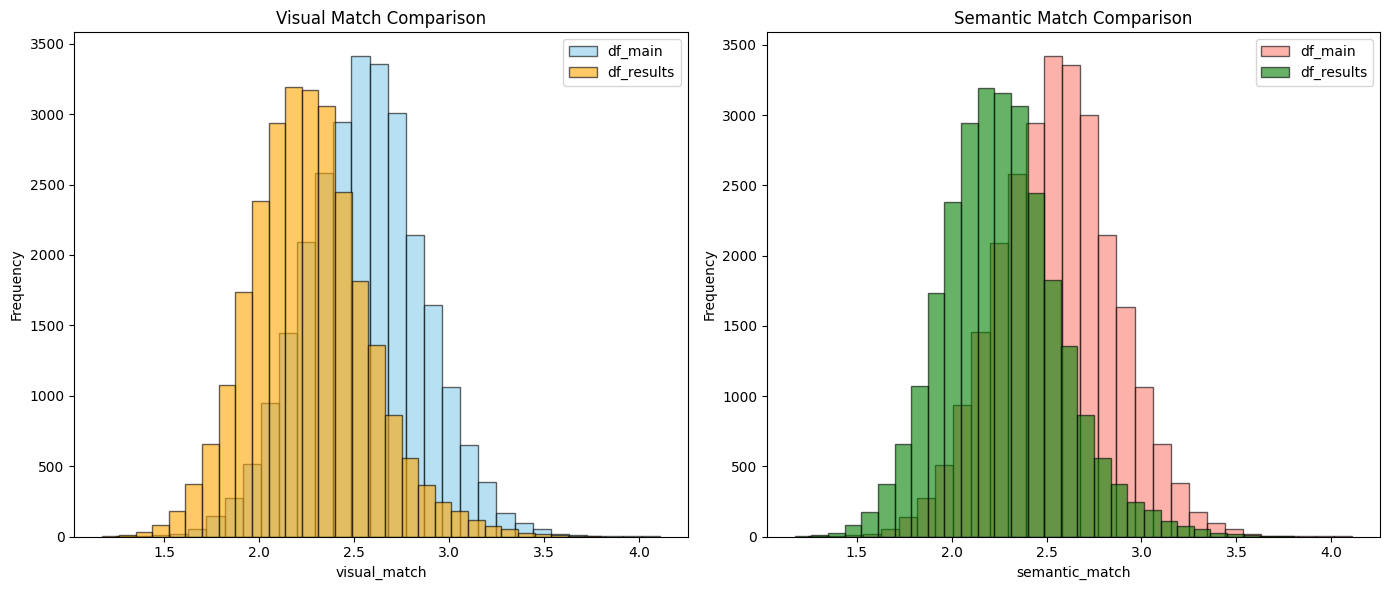

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Visual match comparison
plt.subplot(1, 2, 1)
plt.hist(df_main['visual_match'], bins=30, alpha=0.6, label='df_main', color='skyblue', edgecolor='black')
plt.hist(df_results['visual_match'], bins=30, alpha=0.6, label='df_results', color='orange', edgecolor='black')
plt.title('Visual Match Comparison')
plt.xlabel('visual_match')
plt.ylabel('Frequency')
plt.legend()

# Semantic match comparison
plt.subplot(1, 2, 2)
plt.hist(df_main['semantic_match'], bins=30, alpha=0.6, label='df_main', color='salmon', edgecolor='black')
plt.hist(df_results['semantic_match'], bins=30, alpha=0.6, label='df_results', color='green', edgecolor='black')
plt.title('Semantic Match Comparison')
plt.xlabel('semantic_match')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
XE8YQRGT